# Clustering Ensemble: Instacart

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



## Data preparation

In [2]:
# Product details data
aisles = pd.read_csv('input/aisles.csv')
departments = pd.read_csv('input/departments.csv')
products = pd.read_csv('input/products.csv')

# Merging product details into single dataset
goods = pd.merge(left=pd.merge(products, departments, on='department_id'), 
                 right=aisles, 
                 on='aisle_id').sort_values(['product_id']).reset_index(drop=True)

# Delete redundant datasets
del(products)
del(departments)
del(aisles)

print('There are', goods.shape[0], 'products,',
      goods.aisle_id.nunique(), 'aisles and',
      goods.department_id.nunique(), 'departments.')
goods.head()

There are 49688 products, 134 aisles and 21 departments.


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [3]:
# Prior and train orders
prior = pd.read_csv('input/order_products__prior.csv')
train = pd.read_csv('input/order_products__train.csv')

In [4]:
print('Prior orders shape:', prior.shape)
print('Train orders shape:', train.shape)

Prior orders shape: (32434489, 4)
Train orders shape: (1384617, 4)


In [5]:
df = pd.concat([prior, train])
del(prior)
del(train)
df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
# Orders data
orders = pd.read_csv('input/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
# Merging order details with order micro-details
df = pd.merge(df, orders, on='order_id')
del(orders)
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [8]:
print('Final dataset has a shape of', df.shape, 'which is too large for futher computations!')

Final dataset has a shape of (33819106, 10) which is too large for futher computations!


## Sampling

In [9]:
print('Data has', df.user_id.nunique(), 'unique users')

Data has 206209 unique users


Let's choose $20000$ from those $206209$ users and take a subset from the large data.

In [11]:
sample_ids = df[['user_id']].sample(20000, random_state=42).values.ravel()
sampled_df = df.loc[df['user_id'].isin(sample_ids)].reset_index(drop=True)

print('Shape of sampled data is', sampled_df.shape)
del(df)

Shape of sampled data is (6897850, 10)


In [12]:
sampled_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,4,46842,1,0,178520,prior,36,1,9,7.0
1,4,26434,2,1,178520,prior,36,1,9,7.0
2,4,39758,3,1,178520,prior,36,1,9,7.0
3,4,27761,4,1,178520,prior,36,1,9,7.0
4,4,10054,5,1,178520,prior,36,1,9,7.0


Let's merge final sampled data frame with product details data.

In [13]:
goods_light = goods.drop(['aisle', 'department', 'product_name'], axis=1)
merged_df = pd.merge(sampled_df, goods_light, on='product_id')

In [14]:
merged_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,4,46842,1,0,178520,prior,36,1,9,7.0,93,3
1,4949,46842,4,1,3974,prior,26,3,18,13.0,93,3
2,5322,46842,1,1,27450,prior,6,3,17,4.0,93,3
3,6697,46842,6,0,112723,prior,5,4,15,11.0,93,3
4,6984,46842,6,0,132069,prior,3,6,21,8.0,93,3


## Clustering: Single and Ensemble

Since we have our final data set let us perform user-based clustering on **three** different data-structures.

### 1. User based clustering according to days since prior order and hour of day

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

pc = merged_df[['user_id', 'order_hour_of_day', 'days_since_prior_order', 'order_dow']].groupby(['user_id'], as_index=False).mean()
tocluster = pc[['order_hour_of_day', 'days_since_prior_order', 'order_dow']]
scaler = MinMaxScaler()

tocluster = scaler.fit_transform(tocluster)


In [25]:
pc.head()

,user_id,order_hour_of_day,days_since_prior_order,order_dow
0,15,11.444444,11.029412,2.472222
1,29,10.727273,11.882609,3.553719
2,42,13.057143,13.000000,1.935714
3,43,14.300000,13.462857,2.833333
4,47,15.593750,11.192308,3.437500


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(tocluster)
pca_samples = pca.transform(tocluster)

tocluster = pd.DataFrame(pca_samples)
tocluster.head()

,0,1
0,-0.034879,-0.052277
1,-0.022787,0.126976
2,0.043110,-0.131551
3,0.051747,0.022426
4,-0.026390,0.121361


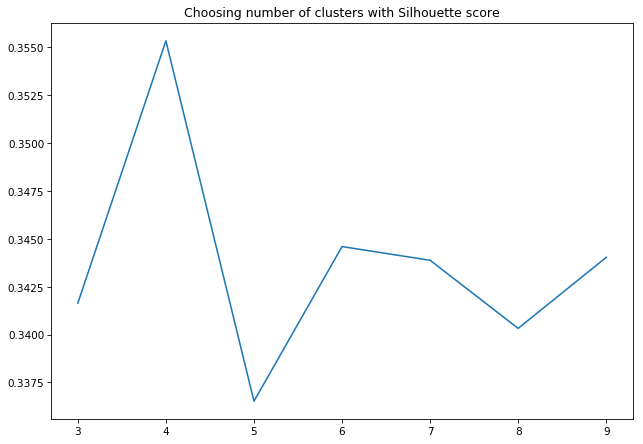

In [27]:
sil_scores = []
for i in range(3, 10):
    clusterer = KMeans(n_clusters=i,random_state=42).fit(tocluster)
    centers = clusterer.cluster_centers_
    c_preds = clusterer.predict(tocluster)
    sil_scores.append(silhouette_score(tocluster, c_preds, sample_size=4000, random_state=42))

fig = plt.figure(figsize=(10,7), dpi=75)
plt.plot(range(3, 10), sil_scores)
plt.title('Choosing number of clusters with Silhouette score')
plt.show()

In [28]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 0.35041916  0.00398873]
 [-0.18416857  0.00951611]
 [ 0.03049537  0.13504369]
 [ 0.01327809 -0.14611307]]


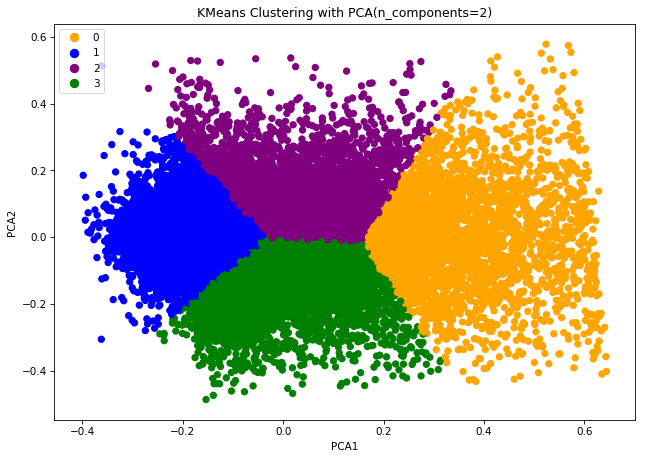

In [29]:
# import matplotlib
fig = plt.figure(figsize=(10,7), dpi=75)
colors = ['orange','blue','purple', 'green']
colored = [colors[k] for k in c_preds]
plt.scatter(tocluster.iloc[:,0],tocluster.iloc[:,1],  color=colored, label='')
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color=colors[ci], label=ci)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('KMeans Clustering with PCA(n_components=2)')
plt.legend(loc='upper left')
plt.show()

In [30]:
cluster1 = c_preds

In [47]:
user_cluster1 = merged_df[['user_id', 'order_hour_of_day', 'days_since_prior_order', 'order_dow']].groupby(['user_id'], as_index=False).mean()
user_cluster1 = user_cluster1.drop(['order_hour_of_day', 'days_since_prior_order', 'order_dow'], axis=1)
user_cluster1['cluster1'] = cluster1
print(user_cluster1.shape)
user_cluster1.head()

(17876, 2)


,user_id,cluster1
0,15,3
1,29,2
2,42,3
3,43,2
4,47,2


### 2. User based time-series clustering

In [15]:
tseries = merged_df[['user_id', 'order_dow', 'product_id']].groupby(['user_id', 'order_dow'])['product_id'].nunique()
tseries = pd.DataFrame(tseries).reset_index()
tseries = pd.pivot_table(data = tseries, columns='order_dow', values='product_id', index='user_id').fillna(0)
tseries
tseries.head(15)

order_dow,0,1,2,3,4,5,6
user_id,,,,,,,
15,0.0,9.0,9.0,0.0,3.0,8.0,6.0
29,0.0,39.0,13.0,18.0,22.0,46.0,14.0
42,23.0,25.0,14.0,35.0,9.0,11.0,0.0
43,32.0,25.0,0.0,13.0,44.0,40.0,0.0
47,0.0,0.0,13.0,0.0,12.0,6.0,1.0
49,0.0,11.0,18.0,7.0,6.0,7.0,3.0
71,40.0,23.0,56.0,63.0,47.0,66.0,26.0
78,25.0,2.0,2.0,0.0,0.0,0.0,14.0
87,31.0,30.0,21.0,19.0,4.0,2.0,18.0


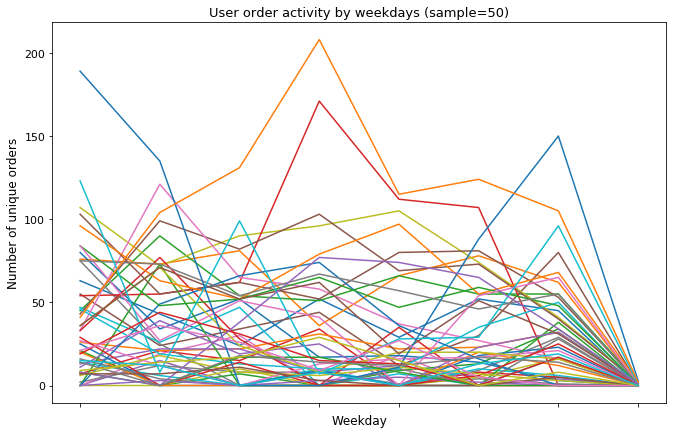

In [219]:
tseries.sample(50, random_state=42).T.plot(legend=False, figsize=(11,7), fontsize=11)
plt.title('User order activity by weekdays (sample=50)', size=13)
plt.xlabel('Weekday', size=12)
plt.ylabel('Number of unique orders', size=12);

In [17]:
tseries.shape

(17876, 7)

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(tseries.sample(1000, random_state=42), 'ward')

In [37]:
cluster_2 = fcluster(Z, 4, criterion='maxclust') - 1

In [32]:
# ! pip install fastdtw
# import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

# x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
# y = np.array([[2,2], [3,3], [4,4]])
# distance, path = fastdtw(x, y, dist=euclidean)
# print(distance)

In [93]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

clf = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
# tseries_sampled = tseries.sample(20000, random_state=42)
clf.fit(tseries.values)
labs = clf.labels_
print(silhouette_score(tseries.values, labs))
tseries['Cluster'] = labs

0.2938838298845228


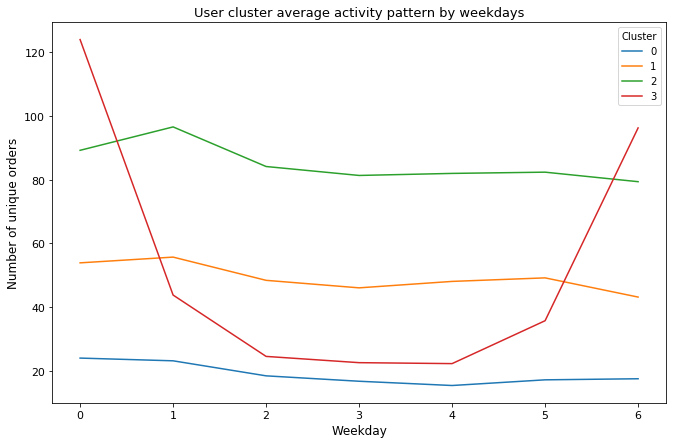

In [94]:
tseries.groupby(['Cluster']).mean().T.plot(legend=True, figsize=(11,7), fontsize=11)
plt.title('User cluster average activity pattern by weekdays', size=13)
plt.xlabel('Weekday', size=12)
plt.ylabel('Number of unique orders', size=12);

In [95]:
cluster2 = labs

In [96]:
user_cluster2 = pd.DataFrame({'user_id': tseries.index, 'cluster2': cluster2})
print(user_cluster2.shape)
user_cluster2.head()

(17876, 2)


,user_id,cluster2
0,15,0
1,29,0
2,42,0
3,43,0
4,47,0


In [97]:
user_cluster2.cluster2.value_counts()

0    11242
1     4209
2     1716
3      709
Name: cluster2, dtype: int64

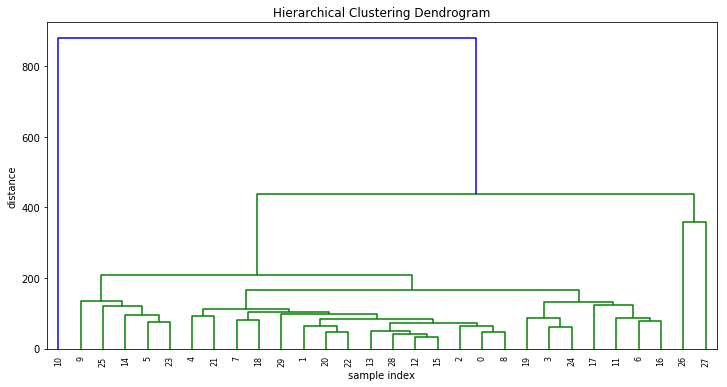

In [33]:
# def dtw_metric(x, y):
#     d, _ = fastdtw(x, y, dist=euclidean)
#     return d

# # Do the clustering    
# Z = linkage(tseries.sample(30),  method='average', metric=dtw_metric)

# # Plot dendogram
# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
# )
# plt.show()


### 3. User based clustering according to aisle preferences

We have 134 unique types of product (aisle).

In [31]:
merged_df.shape

(6897850, 12)

In [32]:
merged_df['aisle_id'].nunique()

134

In [33]:
# Most ordered aisles
merged_df['aisle_id'].value_counts()[0:10]

24     805133
83     746689
123    384019
120    336839
21     217888
84     196723
115    162500
107    154060
91     133825
112    128180
Name: aisle_id, dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler
cust_prod = pd.crosstab(merged_df['user_id'], merged_df['aisle_id'])
scaler = MinMaxScaler()
cust_prod = scaler.fit_transform(cust_prod)

/home/khavan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

pc = pd.DataFrame(pca_samples)
pc.head()

,0,1
0,-0.216781,0.016055
1,-0.114053,0.103512
2,-0.155260,0.022113
3,-0.095741,0.033048
4,-0.216321,0.005444


No handles with labels found to put in legend.


(17876, 2)
          0         1
0 -0.216781  0.016055
1 -0.114053  0.103512
2 -0.155260  0.022113
3 -0.095741  0.033048
4 -0.216321  0.005444


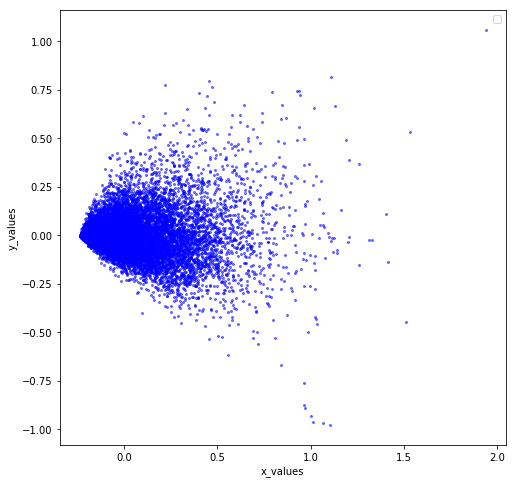

In [36]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(pc)

print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster.iloc[:,0], tocluster.iloc[:,1], 'o', markersize=2, color='blue', alpha=0.5, label='')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

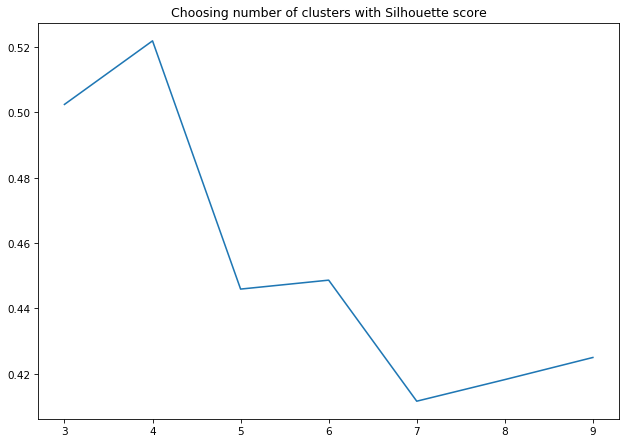

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
for i in range(3, 10):
    clusterer = KMeans(n_clusters=i,random_state=42).fit(tocluster)
    centers = clusterer.cluster_centers_
    c_preds = clusterer.predict(tocluster)
    sil_scores.append(silhouette_score(tocluster, c_preds, sample_size=4000, random_state=42))

fig = plt.figure(figsize=(10,7), dpi=75)
plt.plot(range(3, 10), sil_scores)
plt.title('Choosing number of clusters with Silhouette score')
plt.show()

In [38]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 0.57207317  0.00144855]
 [-0.12742685 -0.00115849]
 [ 0.13217967  0.1671812 ]
 [ 0.15121369 -0.08326213]]


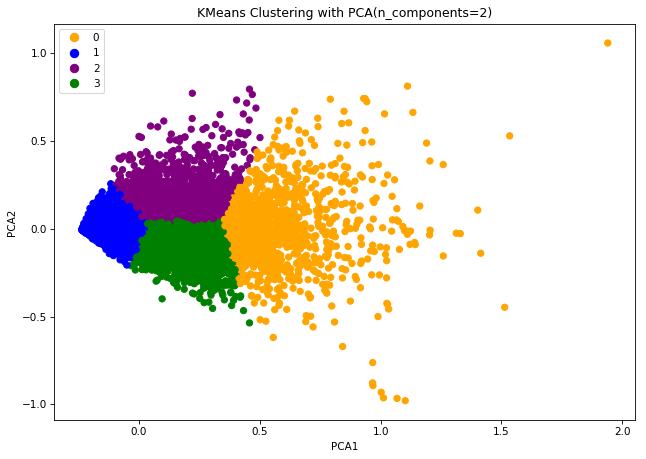

In [39]:
# import matplotlib
fig = plt.figure(figsize=(10,7), dpi=75)
colors = ['orange','blue','purple', 'green']
colored = [colors[k] for k in c_preds]
plt.scatter(tocluster.iloc[:,0],tocluster.iloc[:,1],  color=colored, label='')
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color=colors[ci], label=ci)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('KMeans Clustering with PCA(n_components=2)')
plt.legend(loc='upper left')
plt.show()

In [40]:
cluster3 = c_preds

In [50]:
user_cluster3 = pd.DataFrame({'user_id': pd.crosstab(merged_df['user_id'], merged_df['aisle_id']).index, 'cluster3': cluster3})
print(user_cluster3.shape)
user_cluster3.head()

(17876, 2)


,user_id,cluster3
0,15,1
1,29,1
2,42,1
3,43,1
4,47,1


## Baseline, Cluster and Cluster Ensemble Predictions

Since we have 3 different sets of cluster labels, now we can construct **baseline prediction**, **single cluster prediction** and **cluster ensemble prediction**

In [98]:
cluster_sets = pd.merge(left=pd.merge(user_cluster1, user_cluster2, on='user_id'), right=user_cluster3, on='user_id')
print(cluster_sets.shape)
cluster_sets.tail(15)

(17876, 4)


,user_id,cluster1,cluster2,cluster3
17861,206024,1,0,1
17862,206035,1,2,3
17863,206051,1,0,1
17864,206086,1,2,2
17865,206108,0,3,3
17866,206110,1,0,1
17867,206124,1,0,1
17868,206128,0,0,1
17869,206146,0,1,1
17870,206148,1,0,1


In [107]:
cluster_sets.cluster1.value_counts()

1    6804
3    4102
2    3873
0    3097
Name: cluster1, dtype: int64

In [214]:
for i, row in cluster_sets.iterrows():
    if len(set(row[1:4])) <=2:
        cluster_sets.loc[i, 'clusterens'] = int(max(list(row[1:4]),key=list(row[1:4]).count))
    else:
        cluster_sets.loc[i, 'clusterens'] = int(cluster_sets.loc[i, 'cluster2'])

In [242]:
for i, row in cluster_sets.iterrows():
    
    cluster_sets.loc[i, 'clusterens2'] = str(int(row[1])) + '_' + str(int(row[2])) + '_' + str(int(row[3]))

In [243]:
cluster_sets.head()

,user_id,cluster1,cluster2,cluster3,clusterens,clusterens2
0,15,3,0,1,0.0,3_0_1
1,29,2,0,1,0.0,2_0_1
2,42,3,0,1,0.0,3_0_1
3,43,2,0,1,0.0,2_0_1
4,47,2,0,1,0.0,2_0_1


In [257]:
drop_list = list(cluster_sets.clusterens2.value_counts().index[-11:])

In [215]:
cluster_sets.tail(15)

,user_id,cluster1,cluster2,cluster3,clusterens
17861,206024,1,0,1,1.0
17862,206035,1,2,3,2.0
17863,206051,1,0,1,1.0
17864,206086,1,2,2,2.0
17865,206108,0,3,3,3.0
17866,206110,1,0,1,1.0
17867,206124,1,0,1,1.0
17868,206128,0,0,1,0.0
17869,206146,0,1,1,1.0
17870,206148,1,0,1,1.0


In [126]:
vote = 1 / 3
l = 17876
#co_association matrix is 3X3 (5 patterns)
co_association = np.zeros((l, l))

#for each of your estimators
for lab in [cluster1, cluster2, cluster3]:
    labels = lab
    res = [[int(x == y) for y in labels] for x in labels]
    res = np.array(res)
    #Vote and update the co_association matriz
    res = res * vote
    co_association = co_association + res

In [131]:
co_association > 0.5

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [False, False, False, ..., False, False,  True]])

In [139]:
train = merged_df[merged_df.eval_set == 'train']
test = merged_df[merged_df.eval_set == 'prior']
test = test.sample(120000, random_state=42)
test = test[test.user_id.isin(set(train.user_id))]

In [149]:
y_train = train['reordered']
X_train = train.drop(['eval_set', 'reordered'], axis=1)
y_test = test['reordered']
X_test = test.drop(['eval_set', 'reordered'], axis=1).fillna(0)

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [40, 50],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 50], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 50}

In [144]:
rfc_best = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=8, n_estimators=50, criterion='gini')

In [145]:
rfc_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [147]:
pd.DataFrame({'var': X_train.columns, 'import': rfc_best.feature_importances_})

,var,import
0,order_id,0.021992
1,product_id,0.018355
2,add_to_cart_order,0.160872
3,user_id,0.022530
4,order_number,0.428763
5,order_dow,0.006478
6,order_hour_of_day,0.013043
7,days_since_prior_order,0.151513
8,aisle_id,0.064435
9,department_id,0.112020


In [150]:
from sklearn.metrics import accuracy_score, f1_score

print('Train F1:', f1_score(y_train, rfc_best.predict(X_train)))
print('Train Accuracy:', accuracy_score(y_train, rfc_best.predict(X_train)))

print('Test F1:', f1_score(y_test, rfc_best.predict(X_test)))
print('Test Accuracy:', accuracy_score(y_test, rfc_best.predict(X_test)))

Train F1: 0.8410133893807317
Test F1: 0.8194879203788425
Train Accuracy: 0.7403570723034374
Test Accuracy: 0.7101654724470333


In [154]:
final_scores = pd.DataFrame({'Score': ['Train Accuracy', 'Train F1', 'Test Accuracy', 'Test F1'], 
                             'Baseline prediction': [accuracy_score(y_train, rfc_best.predict(X_train)), 
                             f1_score(y_train, rfc_best.predict(X_train)), 
                             accuracy_score(y_test, rfc_best.predict(X_test)), 
                             f1_score(y_test, rfc_best.predict(X_test))]})
final_scores

,Score,Baseline prediction
0,Train Accuracy,0.740357
1,Train F1,0.841013
2,Test Accuracy,0.710165
3,Test F1,0.819488


In [202]:
X_train_single = pd.merge(X_train, cluster_sets[['user_id', 'cluster1']], on='user_id')
X_test_single = pd.merge(X_test, cluster_sets[['user_id', 'cluster1']], on='user_id')

In [203]:
rfc_best = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=8, n_estimators=50, criterion='gini')
rfc_best.fit(X_train_single, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [204]:
pd.DataFrame({'var': X_train_single.columns, 'import': rfc_best.feature_importances_})

,var,import
0,order_id,0.161614
1,product_id,0.111821
2,add_to_cart_order,0.186288
3,user_id,0.133344
4,order_number,0.086506
5,order_dow,0.033554
6,order_hour_of_day,0.067774
7,days_since_prior_order,0.061202
8,aisle_id,0.071449
9,department_id,0.065759


In [205]:
xgb_best = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1, min_child_weight=)

In [206]:
final_scores

,Score,Baseline prediction,Baseline prediction with single cluster
0,Train Accuracy,0.740357,0.712719
1,Train F1,0.841013,0.832251
2,Test Accuracy,0.710165,0.684107
3,Test F1,0.819488,0.812427


In [216]:
X_train_ens = pd.merge(X_train, cluster_sets[['user_id', 'clusterens']], on='user_id')
X_test_ens = pd.merge(X_test, cluster_sets[['user_id', 'clusterens']], on='user_id')
rfc_best = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=8, n_estimators=50, criterion='gini')
rfc_best.fit(X_train_ens, y_train)
pd.DataFrame({'var': X_train_ens.columns, 'import': rfc_best.feature_importances_})

,var,import
0,order_id,0.157295
1,product_id,0.112735
2,add_to_cart_order,0.176431
3,user_id,0.125192
4,order_number,0.083535
5,order_dow,0.035141
6,order_hour_of_day,0.064293
7,days_since_prior_order,0.057372
8,aisle_id,0.071575
9,department_id,0.063959


In [217]:
final_scores['Baseline prediction with cluster ensemble'] = [accuracy_score(y_train, rfc_best.predict(X_train_ens)), 
                             f1_score(y_train, rfc_best.predict(X_train_ens)), 
                             accuracy_score(y_test, rfc_best.predict(X_test_ens)), 
                             f1_score(y_test, rfc_best.predict(X_test_ens))]

In [218]:
final_scores.round(3)

,Score,Baseline prediction,Baseline prediction with single cluster,Baseline prediction with cluster ensemble
0,Train Accuracy,0.740,0.713,0.713
1,Train F1,0.841,0.832,0.832
2,Test Accuracy,0.710,0.684,0.684
3,Test F1,0.819,0.812,0.812


In [247]:
X_train_ens2 = pd.merge(X_train, cluster_sets[['user_id', 'clusterens2']], on='user_id')
X_test_ens2 = pd.merge(X_test, cluster_sets[['user_id', 'clusterens2']], on='user_id')
rfc_best = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=8, n_estimators=50, criterion='gini')
rfc_best.fit(X_train_ens2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [248]:
final_scores['Baseline prediction with cluster ensemble 2'] = [accuracy_score(y_train, rfc_best.predict(X_train_ens2)), 
                             f1_score(y_train, rfc_best.predict(X_train_ens2)), 
                             accuracy_score(y_test, rfc_best.predict(X_test_ens2)), 
                             f1_score(y_test, rfc_best.predict(X_test_ens2))]

In [249]:
final_scores.round(3)

,Score,Baseline prediction,Baseline prediction with single cluster,Baseline prediction with cluster ensemble,Baseline prediction with cluster ensemble 2
0,Train Accuracy,0.740,0.713,0.713,0.713
1,Train F1,0.841,0.832,0.832,0.832
2,Test Accuracy,0.710,0.684,0.684,0.684
3,Test F1,0.819,0.812,0.812,0.812


In [221]:
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1.5, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5, 7]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1)

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3 )
grid.fit(X_train, y_train)



Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  6.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1.5, 5], 'subsample': [0.6, 1.0], 'colsample_bytree': [0.6, 1.0], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [222]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'max_depth': 7,
 'min_child_weight': 10,
 'subsample': 0.6}

In [227]:
xgb_best = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1, min_child_weight=10, gamma=1.5, subsample=0.6, colsample_bytree=0.6, max_depth=7)
xgb_best.fit(X_train, y_train)
final_scores_xgb = pd.DataFrame({'Score': ['Train Accuracy', 'Train F1', 'Test Accuracy', 'Test F1'], 
                             'Baseline prediction': [accuracy_score(y_train, xgb_best.predict(X_train)), 
                             f1_score(y_train, xgb_best.predict(X_train)), 
                             accuracy_score(y_test, xgb_best.predict(X_test)), 
                             f1_score(y_test, xgb_best.predict(X_test))]})
final_scores_xgb

,Score,Baseline prediction
0,Train Accuracy,0.737702
1,Train F1,0.841651
2,Test Accuracy,0.705127
3,Test F1,0.820198


In [228]:
xgb_best = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1, min_child_weight=10, gamma=1.5, subsample=0.6, colsample_bytree=0.6, max_depth=7)
xgb_best.fit(X_train_single, y_train)
final_scores_xgb['Baseline prediction with single cluster'] = [accuracy_score(y_train, xgb_best.predict(X_train_single)), 
                             f1_score(y_train, xgb_best.predict(X_train_single)), 
                             accuracy_score(y_test, xgb_best.predict(X_test_single)), 
                             f1_score(y_test, xgb_best.predict(X_test_single))]

In [229]:
xgb_best = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1, min_child_weight=10, gamma=1.5, subsample=0.6, colsample_bytree=0.6, max_depth=7)
xgb_best.fit(X_train_ens, y_train)
final_scores_xgb['Baseline prediction with cluster ensemble'] = [accuracy_score(y_train, xgb_best.predict(X_train_ens)), 
                             f1_score(y_train, xgb_best.predict(X_train_ens)), 
                             accuracy_score(y_test, xgb_best.predict(X_test_ens)), 
                             f1_score(y_test, xgb_best.predict(X_test_ens))]

In [230]:
final_scores_xgb

,Score,Baseline prediction,Baseline prediction with single cluster,Baseline prediction with cluster ensemble
0,Train Accuracy,0.737702,0.712644,0.712644
1,Train F1,0.841651,0.832215,0.832215
2,Test Accuracy,0.705127,0.684107,0.684107
3,Test F1,0.820198,0.812427,0.812427


In [258]:
train = merged_df[merged_df.eval_set == 'train']